# CS412 - Machine Learning - Fall 2025
## Homework 3


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

The task in this homework is to perform binary **smiling** classification on a subset of the CelebA dataset using transfer learning.

A pretrained VGG-16 model will be adapted to the task, and its performance will be evaluated under several settings. You will replace the classification head with a binary output layer and train the model for a fixed number of 10 epochs per configuration.

You must:
- Freeze appropriate parts of the pretrained model according to the strategy you choose and only modify the classification head.
- Evaluate your models using the following hyperparameters:
  - 10 epochs
  - Learning rate: 0.0001
  - Fine-tuning strategies:
    1. Freeze all convolutional layers and train only the classifier head.
    2. Freeze all weights except the last convolutional block and the classifier head, and fine-tune those parameters.
- Apply Random Horizontal Flip and a light Color Jitter during training, then discuss how these augmentations affect the smiling classification performance.

**Dataset:** CelebA  
**Model:** VGG-16  
**Library:** PyTorch  

---

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.


## 1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [60]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [61]:
# Import necessary libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

import numpy as np # ?
# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [62]:
data = pd.read_csv('/content/drive/My Drive/CelebA30k.csv') # enter the file path on your drive for the csv file
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [63]:
smile_data = data[['filename', 'Smiling']].copy()
smile_data.head()

,filename,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1


In [11]:
import os

# Unzip ONCE into /content/data
zip_path = "/content/drive/My Drive/CelebA30k.zip"
target_dir = "/content/data/CelebA30k"

if not os.path.exists(target_dir):
    print("Extracting dataset")
    !unzip -q "{zip_path}" -d "/content/data"
    print("Extraction complete")
else:
    print("Dataset already extracted, skipping unzip.")

# Set image directory
img_dir = target_dir
print("Using dataset at:", img_dir)

Extracting dataset
Extraction complete
Using dataset at: /content/data/CelebA30k


In [65]:
first_image_path = os.path.join("/content/data/CelebA30k/", smile_data.loc[0,"filename"])
img = Image.open(first_image_path)

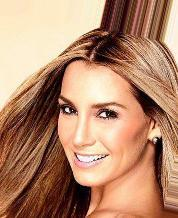

In [31]:
img

# Starting here, you’ll need to fill in the code cells on your own.

## 3) Visualizing/Understanding the dataset

- Display five random images together with their smiling labels.
- Display statistics about the dataset, such as the distribution of smiling vs. not-smiling samples and any other attributes that you find informative.


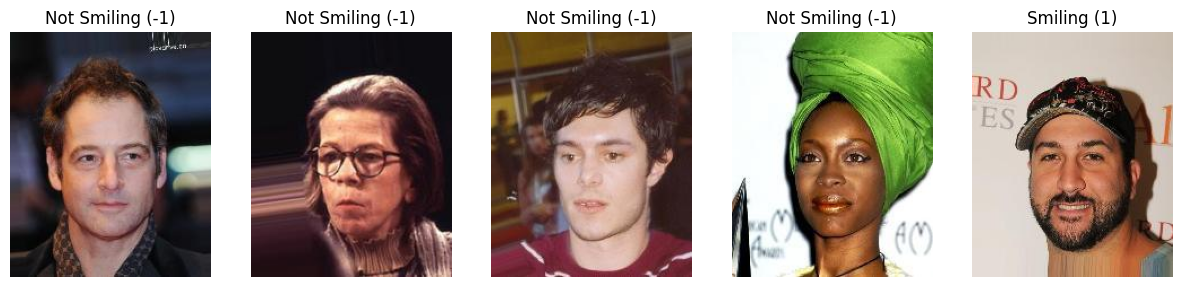

Total Images: 30000
Smiling: 14259 images (47.53%)
Not Smiling: 15741 images (52.47%)


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Select 5 random samples
random_samples = smile_data.sample(n=5, random_state=42)

plt.figure(figsize=(15, 5))

for i, (index, row) in enumerate(random_samples.iterrows()):
    img_name = row.iloc[0]
    label = row['Smiling']

    img_path = os.path.join(img_dir, img_name)


    img = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)

    if label == 1:
        plt.title("Smiling (1)", fontsize=12, )
    else:
        plt.title("Not Smiling (0)", fontsize=12)

    plt.axis('off')

plt.show()

# Dataset Statistics

smile_counts = smile_data['Smiling'].value_counts()
total_samples = len(smile_data)

print(f"Total Images: {total_samples}")
print(f"Smiling: {smile_counts[1]} images ({smile_counts[1] / total_samples:.2%})")

print(f"Not Smiling: {smile_counts[-1]} images ({smile_counts[-1] / total_samples:.2%})")

plt.show()

## 4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [68]:
# 0.2 for test set
train_df, temp_df = train_test_split(smile_data, test_size=0.2, random_state=42, stratify=smile_data['Smiling'])

# validation (%10) and test (%10)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Smiling'])

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 24000, Val size: 3000, Test size: 3000


## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Smiling`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5, 0.5, 0.5]` for simplicity)
   - Include `RandomHorizontalFlip` and a light `ColorJitter` (e.g., low brightness/contrast adjustments) for the training set to satisfy the augmentation requirement
2. Write a custom `Dataset` class that reads images and smiling labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size.
4. Keep notes on how the applied augmentations might influence the smiling classification results so you can reflect on them in your discussion


In [69]:
class CelebADataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]

        raw_label = int(self.df.iloc[idx]['Smiling'])
        label = 1 if raw_label == 1 else 0

        img_path = os.path.join(self.root_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Transforms - Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset and DataLoader
train_dataset = CelebADataset(train_df, img_dir, transform=train_transforms)
val_dataset = CelebADataset(val_df, img_dir, transform=test_val_transforms)
test_dataset = CelebADataset(test_df, img_dir, transform=test_val_transforms)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle - randomize
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for smiling classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with weights=models.VGG16_Weights.IMAGENET1K_V1 torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [70]:
# Models -- free_all or fine_tune

def get_vgg_model(strategy="freeze_all"):
    # Pretrained VGG16
    # Deprecation warning fix: Use weights argument instead of pretrained
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)


    # Last layer of VGG16 (6) is Linear(4096, 1000), make it (4096, 1).
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 1)

    if strategy == "freeze_all":
        # Freeze all of them
        for param in model.features.parameters():
            param.requires_grad = False # No gradient, no update for weights

    elif strategy == "fine_tune":
        # Freeze all of them
        for param in model.features.parameters():
            param.requires_grad = False

        # Just unfreeze last layers for fine_tune
        for param in model.features[24:].parameters():
            param.requires_grad = True

    # Classifier must be trained for both models.
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model.to(device)


# Training Loop

import time

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_total = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0


        total_steps = len(train_loader)
        # 375 * 64 = 24,000
        # Batch size was 64, then train_loader has 375 elements
        # Train set has 24,000 elements
        print(f"\nEpoch {epoch+1}/{num_epochs}...") # Log, be sure that code works

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            # Another log to see loss, see performance of model in this epoch
            if (i + 1) % 150 == 0:
                print(f"  [Epoch {epoch+1}] Step {i+1}/{total_steps}. Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation for each epoch, at the end of each epoch
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        duration = time.time() - epoch_start
        print(f"Epoch {epoch+1}, ({duration:.0f}sn) - "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    total_time = time.time() - start_total
    print(f"\nTotal time: {total_time/60:.2f} minutes.")
    return train_losses, train_accs, val_losses, val_accs

## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:

- Experiment with the two required fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block together with the classifier head and fine-tune those parameters while keeping the earlier layers frozen.
- Use `nn.BCEWithLogitsLoss()` as the loss function and choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- For each fine-tuning strategy, train models with `learning rate = 0.0001`). Each configuration must run for exactly 10 epochs with the mandated data augmentation pipeline.
- Implement a training loop that includes validation after each epoch and monitor both training and validation performance across epochs.
- Keep track of the training duration and include it in your reports.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

**Reporting requirements:**

- Final training and validation accuracy for both configurations.
- Plots for each setup, showing training and validation loss across epochs.
- A table showing training-validation loss, accuracy, and training duration of the models.
- A discussion regarding:
  1. Which fine-tuning strategy performed best and why,
  2. How the Random Horizontal Flip + Color Jitter augmentation influenced the results.


**Note:** Normally, this setup is not optimal for hyperparameter tuning and you would want to experiment with different learning rates, batch sizes, freezing strategies etc. The tuned parameters were kept limited to have reasonable training times and GPU consumptions in this study. If you are curious, you are more than welcome to experiment with other parameters. Especially, `learning rate = 0.001` gives interesting results when used in a fine-tuned model (i.e. when the last convolutional block is not frozen).   


Freeze all layers: 

Epoch 1/10...
  [Epoch 1] Step 150/375. Loss: 0.4260
  [Epoch 1] Step 300/375. Loss: 0.4455
Epoch 1, (352sn) - Train Loss: 0.4352, Acc: 0.7927 | Val Loss: 0.3422, Val Acc: 0.8470

Epoch 2/10...
  [Epoch 2] Step 150/375. Loss: 0.2327
  [Epoch 2] Step 300/375. Loss: 0.2362
Epoch 2, (346sn) - Train Loss: 0.3376, Acc: 0.8495 | Val Loss: 0.3287, Val Acc: 0.8497

Epoch 3/10...
  [Epoch 3] Step 150/375. Loss: 0.2853
  [Epoch 3] Step 300/375. Loss: 0.2919
Epoch 3, (346sn) - Train Loss: 0.2964, Acc: 0.8701 | Val Loss: 0.3177, Val Acc: 0.8577

Epoch 4/10...
  [Epoch 4] Step 150/375. Loss: 0.2694
  [Epoch 4] Step 300/375. Loss: 0.3287
Epoch 4, (345sn) - Train Loss: 0.2666, Acc: 0.8866 | Val Loss: 0.3153, Val Acc: 0.8600

Epoch 5/10...
  [Epoch 5] Step 150/375. Loss: 0.1285
  [Epoch 5] Step 300/375. Loss: 0.1575
Epoch 5, (345sn) - Train Loss: 0.2425, Acc: 0.8967 | Val Loss: 0.3462, Val Acc: 0.8513

Epoch 6/10...
  [Epoch 6] Step 150/375. Loss: 0.2097
  [Epoch 6] Step 300/375. 

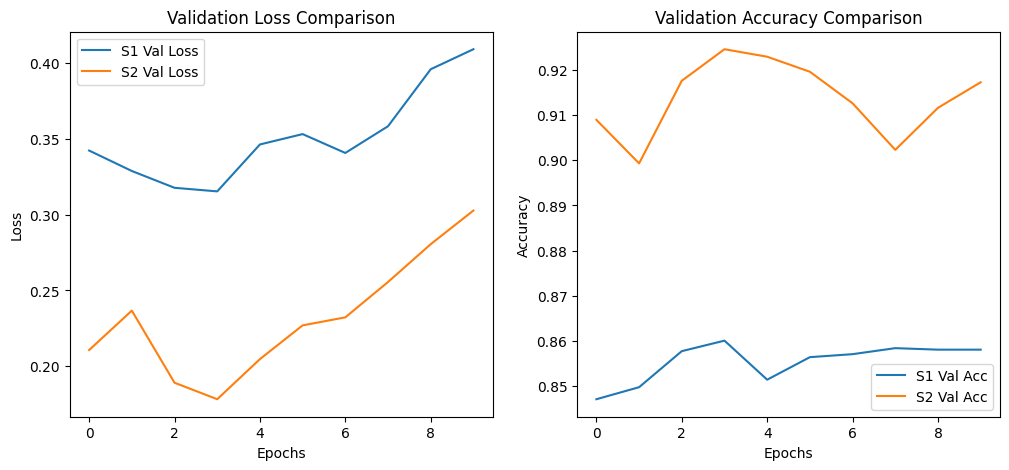

In [71]:
# Experiment --- Training

# Freeze all layers just train classifier
print("Freeze all layers: ")
model_s1 = get_vgg_model(strategy="freeze_all")
criterion = nn.BCEWithLogitsLoss()
optimizer_s1 = optim.Adam(filter(lambda p: p.requires_grad, model_s1.parameters()), lr=0.0001)

hist_s1 = train_model(model_s1, train_loader, val_loader, criterion, optimizer_s1, num_epochs=10)

# Unfreeze last layers, and train them
print("\nFine-tune: ")
model_s2 = get_vgg_model(strategy="fine_tune")
# Lower learning rate for fine-tune, ai suggested
optimizer_s2 = optim.Adam(filter(lambda p: p.requires_grad, model_s2.parameters()), lr=0.0001)

hist_s2 = train_model(model_s2, train_loader, val_loader, criterion, optimizer_s2, num_epochs=10)

# Visualize

# Loss comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_s1[2], label='S1 Val Loss')
plt.plot(hist_s2[2], label='S2 Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(hist_s1[3], label='S1 Val Acc')
plt.plot(hist_s2[3], label='S2 Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 8) Test your classifier on Test set

- Determine the setup with the best performance based on validation set performance.
- Use your model to predict the labels of the test set and report the final accuracy.
- Display the confusion matrix.
- Display 5 correct, 5 incorrect classifications.
- Include the findings in your report, and ensure that the distinction between training and test results is clearly distinguishable.


Strategy 1 on Test Set

Results for Strategy 1:
  - Test Loss: 0.4163
  - Test Accuracy: 0.8540


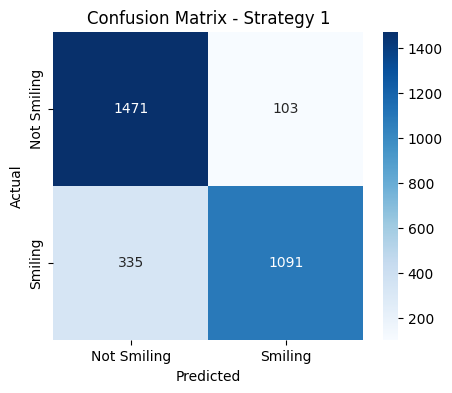


Strategy 2 on Test Set 

Results for Strategy 2:
  - Test Loss: 0.3122
  - Test Accuracy: 0.9063


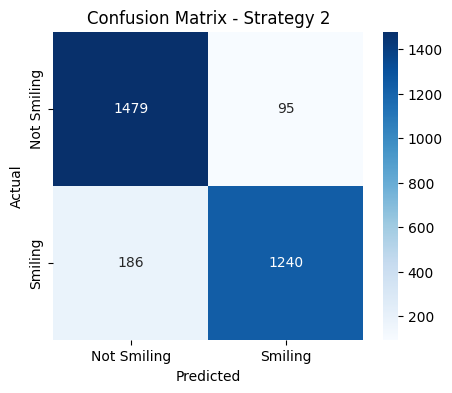


Selecting Best Model 
Strategy 1 Final Val Acc: 0.8580
Strategy 2 Final Val Acc: 0.9173
Best Model Decision: Strategy 2 

Model                     | Test Loss  | Test Acc  
--------------------------------------------------
Strategy 1 (Freeze All)   | 0.4163     | 0.8540
Strategy 2 (Fine-Tune)    | 0.3122     | 0.9063


In [72]:
# Loss + Accuracy + Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
def evaluate_test_performance(model, test_loader, criterion, model_name="Model"):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels_tensor = labels.to(device).unsqueeze(1)

            outputs = model(images)

            # Loss Calculation
            loss = criterion(outputs, labels_tensor)
            test_loss += loss.item() * images.size(0)

            # Accuracy Calculation
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (preds == labels_tensor).sum().item()
            total_test += labels.size(0)

            # Store predictions for Confusion Matrix
            all_preds.extend(preds.cpu().squeeze().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_acc = correct_test / total_test

    print(f"\nResults for {model_name}:")
    print(f"  - Test Loss: {avg_test_loss:.4f}")
    print(f"  - Test Accuracy: {avg_test_acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Smiling', 'Smiling'],
                yticklabels=['Not Smiling', 'Smiling'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return avg_test_loss, avg_test_acc


criterion = nn.BCEWithLogitsLoss()

# 1. Evaluate Strategy 1 (Freeze All) on Test Set
print("Strategy 1 on Test Set")
test_loss_s1, test_acc_s1 = evaluate_test_performance(model_s1, test_loader, criterion, model_name="Strategy 1")

# 2. Evaluate Strategy 2 (Fine-Tune) on Test Set
print("\nStrategy 2 on Test Set ")
test_loss_s2, test_acc_s2 = evaluate_test_performance(model_s2, test_loader, criterion, model_name="Strategy 2")

print("\nSelecting Best Model ")
val_acc_s1 = hist_s1[3][-1] # Last epoch validation accuracy of S1
val_acc_s2 = hist_s2[3][-1] # Last epoch validation accuracy of S2

print(f"Strategy 1 Final Val Acc: {val_acc_s1:.4f}")
print(f"Strategy 2 Final Val Acc: {val_acc_s2:.4f}")

if val_acc_s1 > val_acc_s2:
    print("Best Model Decision: Strategy 1 ")
    best_model = model_s1
else:
    print("Best Model Decision: Strategy 2 ")
    best_model = model_s2

# 4. Final Comparison Table
print("\n" + "="*50)
print(f"{'Model':<25} | {'Test Loss':<10} | {'Test Acc':<10}")
print("-" * 50)
print(f"{'Strategy 1 (Freeze All)':<25} | {test_loss_s1:.4f}     | {test_acc_s1:.4f}")
print(f"{'Strategy 2 (Fine-Tune)':<25} | {test_loss_s2:.4f}     | {test_acc_s2:.4f}")
print("="*50)

Total Correct: 121, Total Incorrect: 7

Corrects


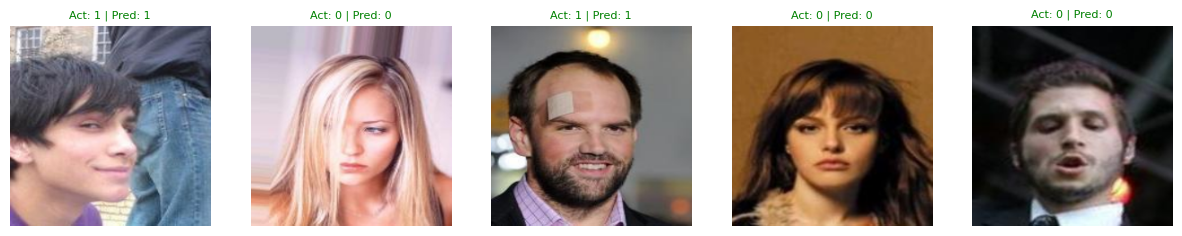


Incorrects


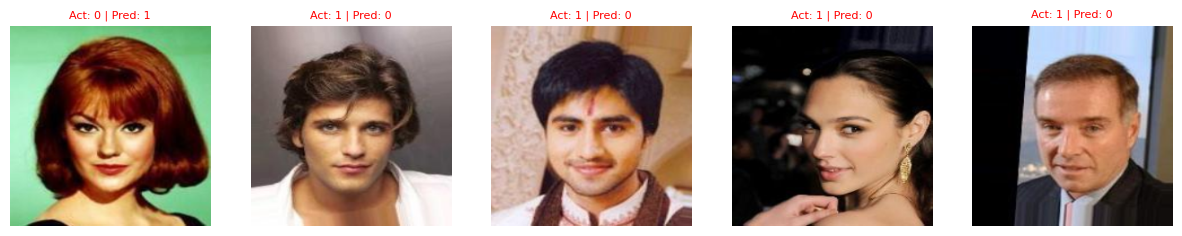

In [73]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()

    correct_indices = []
    incorrect_indices = []

    # Collect examples iterating batches
    all_imgs = []
    all_lbls = []
    all_preds = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float().squeeze()

            # cuda, device to host
            all_imgs.extend(inputs.cpu())
            all_lbls.extend(labels.cpu())
            all_preds.extend(preds.cpu())

            if len(all_imgs) > 100: # First 128 pictures from test set
                break

    # Separate correct and incorrect predictions
    for idx, (p, l) in enumerate(zip(all_preds, all_lbls)):
        if p == l:
            correct_indices.append(idx)
        else:
            incorrect_indices.append(idx)

    print(f"Total Correct: {len(correct_indices)}, Total Incorrect: {len(incorrect_indices)}")

    print("\nCorrects")
    plt.figure(figsize=(15, 3))
    for i in range(min(num_images, len(correct_indices))):
        idx = correct_indices[i]
        ax = plt.subplot(1, num_images, i+1)
        img = all_imgs[idx].permute(1, 2, 0).numpy()

        # Denormalize the image (using the same mean/std as applied during transform)
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f"Act: {int(all_lbls[idx])} | Pred: {int(all_preds[idx])}", fontsize=8, color='green')
        ax.axis('off')
    plt.show()

    print("\nIncorrects")
    plt.figure(figsize=(15, 3))
    for i in range(min(num_images, len(incorrect_indices))):
        idx = incorrect_indices[i]
        ax = plt.subplot(1, num_images, i+1)
        img = all_imgs[idx].permute(1, 2, 0).numpy()

        # Denormalize
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f"Act: {int(all_lbls[idx])} | Pred: {int(all_preds[idx])}", fontsize=8, color='red')
        ax.axis('off')
    plt.show()

visualize_predictions(best_model, test_loader, num_images=5)


 Extra Experiment: To see the effect of Augmentation, using Strategy 1

Epoch 1/10...
  [Epoch 1] Step 150/375. Loss: 0.4679
  [Epoch 1] Step 300/375. Loss: 0.3004
Epoch 1, (216sn) - Train Loss: 0.4210, Acc: 0.8017 | Val Loss: 0.3363, Val Acc: 0.8470

Epoch 2/10...
  [Epoch 2] Step 150/375. Loss: 0.3078
  [Epoch 2] Step 300/375. Loss: 0.1835
Epoch 2, (215sn) - Train Loss: 0.2813, Acc: 0.8760 | Val Loss: 0.3348, Val Acc: 0.8577

Epoch 3/10...
  [Epoch 3] Step 150/375. Loss: 0.1022
  [Epoch 3] Step 300/375. Loss: 0.1928
Epoch 3, (215sn) - Train Loss: 0.1966, Acc: 0.9190 | Val Loss: 0.4116, Val Acc: 0.8367

Epoch 4/10...
  [Epoch 4] Step 150/375. Loss: 0.0910
  [Epoch 4] Step 300/375. Loss: 0.2808
Epoch 4, (220sn) - Train Loss: 0.1299, Acc: 0.9459 | Val Loss: 0.4390, Val Acc: 0.8453

Epoch 5/10...
  [Epoch 5] Step 150/375. Loss: 0.0261
  [Epoch 5] Step 300/375. Loss: 0.0677
Epoch 5, (219sn) - Train Loss: 0.0819, Acc: 0.9679 | Val Loss: 0.5400, Val Acc: 0.8483

Epoch 6/10...
  [Epoch 6] S

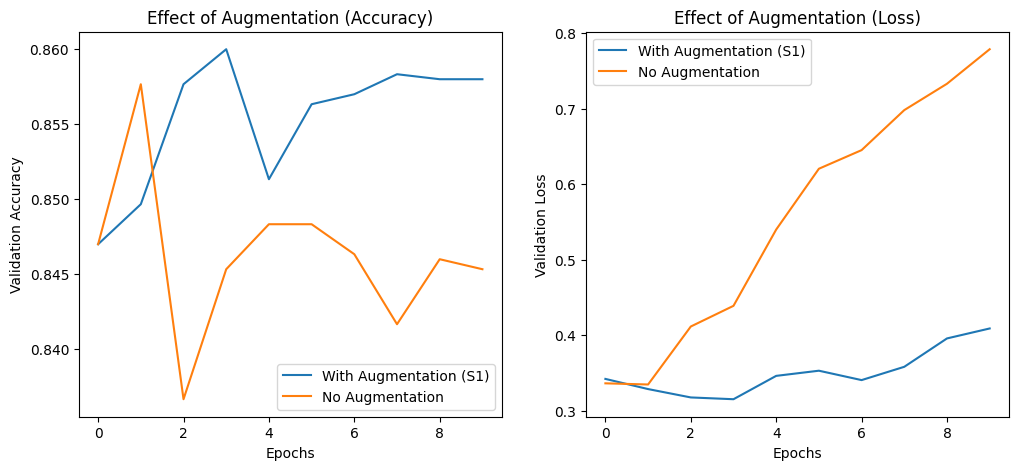

In [75]:
print("\n Extra Experiment: To see the effect of Augmentation, using Strategy 1")

# A training dataset without Augmentation
train_dataset_no_aug = CelebADataset(train_df, img_dir, transform=test_val_transforms)
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=batch_size, shuffle=True)

# New model without augmentation
model_no_aug = get_vgg_model(strategy="freeze_all")

# Apply the filter optimization
optimizer_no_aug = optim.Adam(filter(lambda p: p.requires_grad, model_no_aug.parameters()), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

# 3. Start training
hist_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion, optimizer_no_aug, num_epochs=10)

# 4. Graph to Compare Results (Augmented vs No-Augmented)
plt.figure(figsize=(12, 5))

# Validation Accuracy Difference
plt.subplot(1, 2, 1)
plt.plot(hist_s1[3], label='With Augmentation (S1)') # S1 from the previous run
plt.plot(hist_no_aug[3], label='No Augmentation')
plt.title('Effect of Augmentation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Validation Loss Difference
plt.subplot(1, 2, 2)
plt.plot(hist_s1[2], label='With Augmentation (S1)')
plt.plot(hist_no_aug[2], label='No Augmentation')
plt.title('Effect of Augmentation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.show()


Results for Strategy 1 no augmentation:
  - Test Loss: 0.7147
  - Test Accuracy: 0.8513


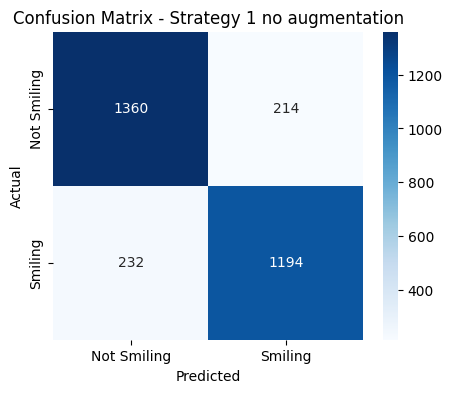


Model                     | Test Loss  | Test Acc  
--------------------------------------------------
Strategy 1 (Freeze All)   | 0.4163     | 0.8540
Strategy 1 (No Augmentation) | 0.7147     | 0.8513


In [77]:
test_loss_s1_no_aug, test_acc_s1_no_aug = evaluate_test_performance(model_no_aug, test_loader, criterion, model_name="Strategy 1 no augmentation")

# 4. Final Comparison Table
print("\n" + "="*50)
print(f"{'Model':<25} | {'Test Loss':<10} | {'Test Acc':<10}")
print("-" * 50)
print(f"{'Strategy 1 (Freeze All)':<25} | {test_loss_s1:.4f}     | {test_acc_s1:.4f}")
print(f"{'Strategy 1 (No Augmentation)':<25} | {test_loss_s1_no_aug:.4f}     | {test_acc_s1_no_aug:.4f}")
print("="*50)